**Table of contents**<a id='toc0_'></a>    
- [<b>Load Dataset</b>](#toc1_)    
    - [Load Config Data](#toc1_1_1_)    
    - [Load Dataset](#toc1_1_2_)    
- [<b> Feature Selection </b>](#toc2_)    
  - [<b>1. Categorical vs Categorical (Binary Classification)</b>](#toc2_1_)    
    - [<b>Chi-Squared Test</b>](#toc2_1_1_)    
  - [<b>2. Numeric vs Categoric (Binary Classification)</b>](#toc2_2_)    
    - [<b>Normality Test: Shapiro-Wilk Test</b>](#toc2_2_1_)    
    - [<b>Normality Test: Probability Plot</b>](#toc2_2_2_)    
    - [<b>Equal Variance Test: Levene Test</b>](#toc2_2_3_)    
    - [**Welch T-Test**](#toc2_2_4_)    
  - [<b>3. Numeric vs Numeric (Multicollinearity)</b>](#toc2_3_)    
  - [<b>4. Lasso Method</b>](#toc2_4_)    
  - [<b>5. XGBoost Method</b>](#toc2_5_)    
  - [<b>6. Random Forest</b>](#toc2_6_)    
- [<b>Handling Imbalance Data</b>](#toc3_)    
  - [<b>Balancing</b>](#toc3_1_)    
  - [<b> Selected Features</b>](#toc3_2_)    
  - [Check Map Correlations using PPS](#toc3_3_)    
  - [Handling Outliers data](#toc3_4_)    
  - [Pairplot](#toc3_5_)    
- [Store Data to Directory](#toc4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [12]:
## Load Configuration File

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import src.util as util
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTENC
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LassoCV
from xgboost import XGBClassifier

import warnings

warnings.filterwarnings('ignore')


In [13]:
sns.set_style('darkgrid')
sns.set(rc = {'axes.facecolor': '#FBFBFB', 'figure.facecolor': '#FBFBFB'})

class clr:
    start = '\033[93m'+'\033[1m'
    bold = '\033[1m'
    underline = '\033[4m'
    color = '\033[93m'
    end = '\033[0m'

# <a id='toc1_'></a>[<b>Load Dataset</b>](#toc0_)

In [14]:
def load_dataset(config_data: dict) -> pd.DataFrame:
    # Load set of data
    x_train = util.pickle_load(config_data["train_set_path"][0])
    y_train = util.pickle_load(config_data["train_set_path"][1])

    x_valid = util.pickle_load(config_data["valid_set_path"][0])
    y_valid = util.pickle_load(config_data["valid_set_path"][1])

    x_test = util.pickle_load(config_data["test_set_path"][0])
    y_test = util.pickle_load(config_data["test_set_path"][1])

    # concatenate x and y each set
    train_set = pd.concat([x_train, y_train], axis = 1)
    valid_set = pd.concat([x_valid, y_valid], axis = 1)
    test_set = pd.concat([x_test, y_test], axis = 1)

    # return 3 set of data
    return train_set, valid_set, test_set

### <a id='toc1_1_1_'></a>[Load Config Data](#toc0_)

In [15]:
config_data = util.load_config()

### <a id='toc1_1_2_'></a>[Load Dataset](#toc0_)

In [16]:
train_set, valid_set, test_set = load_dataset(config_data)

In [17]:
list_num_col = []

for col in train_set.columns:
    if (train_set[col].dtype =='int32'):
        list_num_col.append(col)

list_cat_col = []

for col in train_set.columns:
    if (train_set[col].dtype =='object'):
        list_cat_col.append(col)

# <a id='toc2_'></a>[<b> Feature Selection </b>](#toc0_)

-----

## <a id='toc2_1_'></a>[<b>1. Categorical vs Categorical (Binary Classification)</b>](#toc0_)

### <a id='toc2_1_1_'></a>[<b>Chi-Squared Test</b>](#toc0_)

**Null Hypothesis**: The two categorical variables have no relationship (independent) <br>
**Alternate Hypothesis**: There is a relationship between two categorical variables (dependannt)


> <b>H<sub>0</sub></b> : (Feature not important)<br> 
> <b>H<sub>1</sub></b> : (Feature important)

Null Hypothesis is trying to tell the probability of observing data at least as extreme as the ones we've observed is assuming the <b>all categories in features did in reality have the same frequency of fraud.</b>


In [18]:
from scipy.stats import chi2_contingency

X_cat = train_set[list_cat_col].loc[:, ~train_set[list_cat_col].columns.isin(['fraud_reported'])]
y_cat = train_set['fraud_reported']

alpha = 0.05
p_values_ = dict()

for col in X_cat.columns:

    chi2_data = pd.crosstab(X_cat[col], y_cat)

    chi2, p, dof, expected = chi2_contingency(chi2_data)

    p_values_.setdefault('column', []).append(col)
    p_values_.setdefault('p_values', []).append(p)
    p_values_.setdefault('chi2', []).append(chi2)

    if p < alpha:
        p_values_.setdefault('result', []).append('Reject Ho')        

    else:
        p_values_.setdefault('result', []).append('Failed to Reject Ho') 

chi2_data = pd.DataFrame(p_values_).set_index('column')
chi2_data

,p_values,chi2,result
column,,,
policy_deductable,7.055207e-01,0.697638,Failed to Reject Ho
umbrella_limit,2.743551e-01,12.162087,Failed to Reject Ho
number_of_vehicles_involved,5.604340e-01,2.058109,Failed to Reject Ho
bodily_injuries,1.813591e-01,3.414552,Failed to Reject Ho
witnesses,1.142818e-01,5.945707,Failed to Reject Ho
auto_year,3.724344e-01,21.426290,Failed to Reject Ho
policy_state,8.439488e-01,0.339327,Failed to Reject Ho
policy_csl,7.358715e-01,0.613400,Failed to Reject Ho
insured_sex,1.000000e+00,0.000000,Failed to Reject Ho


In [19]:
chi_score_feature = chi2_data[chi2_data['result']=='Reject Ho'].index.to_list()
chi_score_feature

['insured_hobbies',
 'incident_type',
 'collision_type',
 'incident_severity',
 'authorities_contacted',
 'incident_state',
 'property_damage']

In [20]:
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

chi2_data_2 = train_set.copy()

for col in X_cat.columns:

    chi2_data_2[col] = label_encoder.fit_transform(chi2_data_2[col])

chi2_data_2.fraud_reported = label_encoder.fit_transform(chi2_data_2.fraud_reported)

chi_score = chi2(chi2_data_2[X_cat.columns], chi2_data_2.fraud_reported)

p_values_ = pd.Series(chi_score[1], index = chi2_data_2[X_cat.columns].columns)

In [21]:
p_values_[p_values_ < 0.05]

umbrella_limit           2.451398e-06
insured_hobbies          5.103306e-03
collision_type           1.033663e-03
incident_severity        9.759006e-21
authorities_contacted    1.920248e-04
dtype: float64

## <a id='toc2_2_'></a>[<b>2. Numeric vs Categoric (Binary Classification)</b>](#toc0_)

### <a id='toc2_2_1_'></a>[<b>Normality Test: Shapiro-Wilk Test</b>](#toc0_)

In [22]:
from statsmodels.formula.api import ols
from scipy.stats import shapiro

shapiro_ = {}

for i,col in enumerate(list_num_col):
    model = ols(f'{col} ~ fraud_reported', data=pd.concat([train_set[list_num_col], train_set['fraud_reported']], axis=1)).fit()

    shapiro_.setdefault('column', []).append(col)
    shapiro_.setdefault('shapiro', []).append(shapiro(model.resid)[1])

    if shapiro(model.resid)[1] < 0.01:
        shapiro_.setdefault('result', []).append('Reject Ho')
    else:
        shapiro_.setdefault('result', []).append('Failed to Reject Ho')

shapiro_ = pd.DataFrame(shapiro_).set_index('column')

In [23]:
shapiro_


,shapiro,result
column,,
months_as_customer,5.370890e-10,Reject Ho
age,1.068292e-09,Reject Ho
policy_number,4.490583e-14,Reject Ho
policy_annual_premium,7.273356e-01,Failed to Reject Ho
insured_zip,6.829603e-34,Reject Ho
capital_gains,2.208908e-30,Reject Ho
capital_loss,8.032668e-29,Reject Ho
incident_hour_of_the_day,9.508030e-15,Reject Ho
total_claim_amount,1.544749e-17,Reject Ho


### <a id='toc2_2_2_'></a>[<b>Normality Test: Probability Plot</b>](#toc0_)

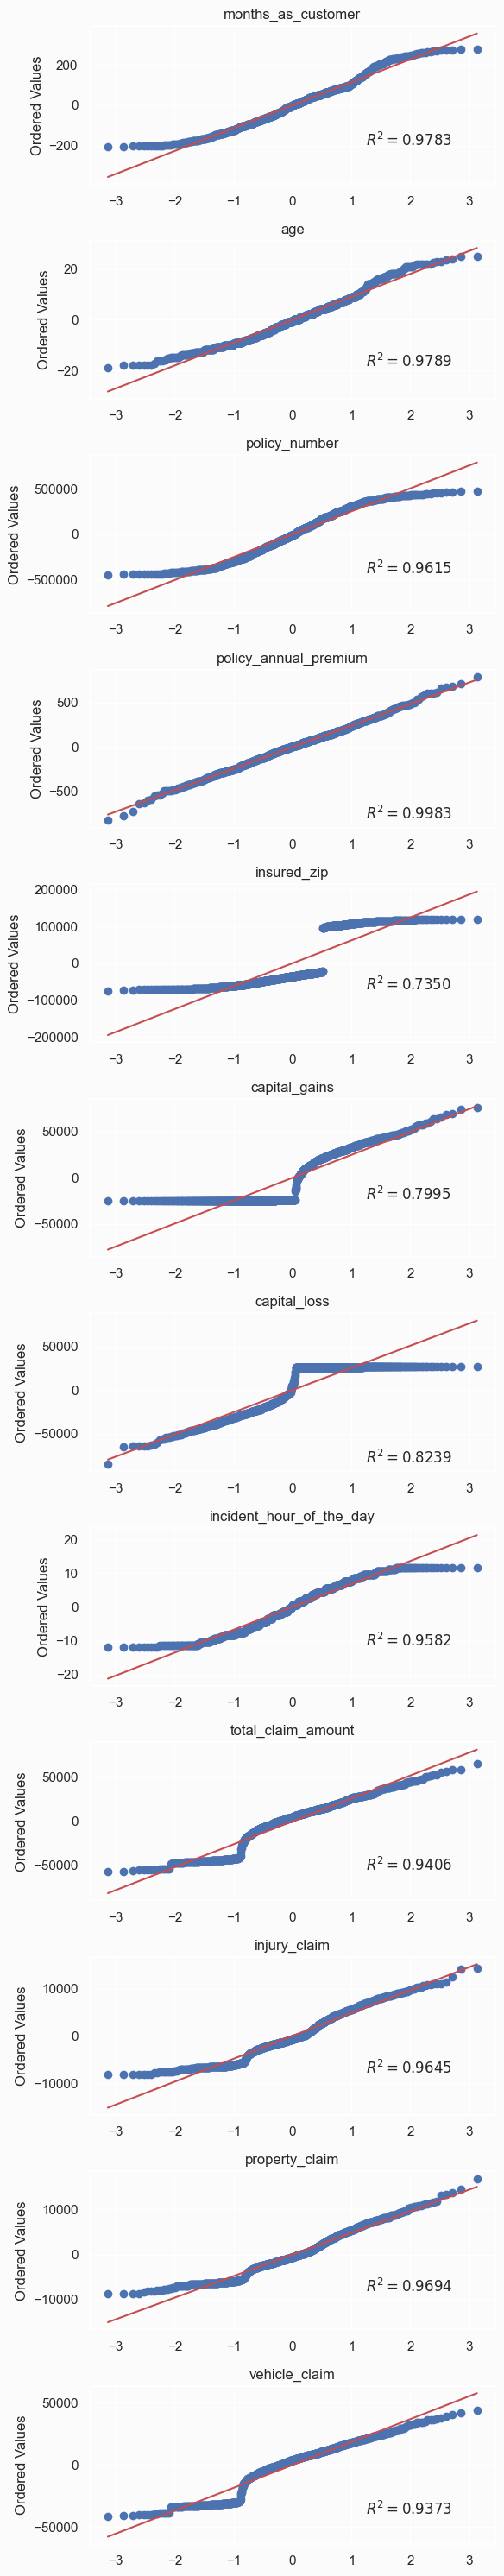

In [24]:
from scipy.stats import probplot

fig, axes = plt.subplots(12, 1, figsize=(6,30))

for i, col in enumerate(list_num_col):

    model = ols(f'{col} ~ fraud_reported', data=pd.concat([train_set[list_num_col], train_set['fraud_reported']], axis=1)).fit()

    normality_plot, stat = probplot(model.resid, plot = axes[i], rvalue = True)

    axes[i].set_title(col)
    axes[i].set_xlabel('')
    

fig.tight_layout()
plt.show()

### <a id='toc2_2_3_'></a>[<b>Equal Variance Test: Levene Test</b>](#toc0_)

- **Null Hypothesis:** Equal Variances
- **Alternative Hypothesis:** Inequal Variances

In [25]:
from scipy.stats import levene

levene_test = dict()

for col in list_num_col:

    levene_ = levene(
                        train_set[col][train_set['fraud_reported']=='Y'],
                        train_set[col][train_set['fraud_reported']=='N']
                    )
    
    levene_test.setdefault('column',[]).append(col)
    levene_test.setdefault('levene',[]).append(levene_[1])

    if levene_[1] < 0.01:
        levene_test.setdefault('result', []).append('Reject Ho')

    else:
        levene_test.setdefault('result', []).append('Failed to Reject Ho')

levene_test = pd.DataFrame(levene_test).set_index('column')
levene_test

,levene,result
column,,
months_as_customer,0.255101,Failed to Reject Ho
age,0.184850,Failed to Reject Ho
policy_number,0.983943,Failed to Reject Ho
policy_annual_premium,0.662281,Failed to Reject Ho
insured_zip,0.735818,Failed to Reject Ho
capital_gains,0.617612,Failed to Reject Ho
capital_loss,0.985661,Failed to Reject Ho
incident_hour_of_the_day,0.591711,Failed to Reject Ho
total_claim_amount,0.000008,Reject Ho


### <a id='toc2_2_4_'></a>[**Welch T-Test**](#toc0_)

        Equal Variance would perform Independence T-Test.
        Non-Equal Variance would perform Welch's Test.

-------------------------
        H0 : There's no difference mean between var1 and var2,
        H1 : There's difference mean between var1 and var2,
>**H₀ : μ₁ = μ₂** <br>

>**H₁ : μ₁ ≠ μ₂**
<br>

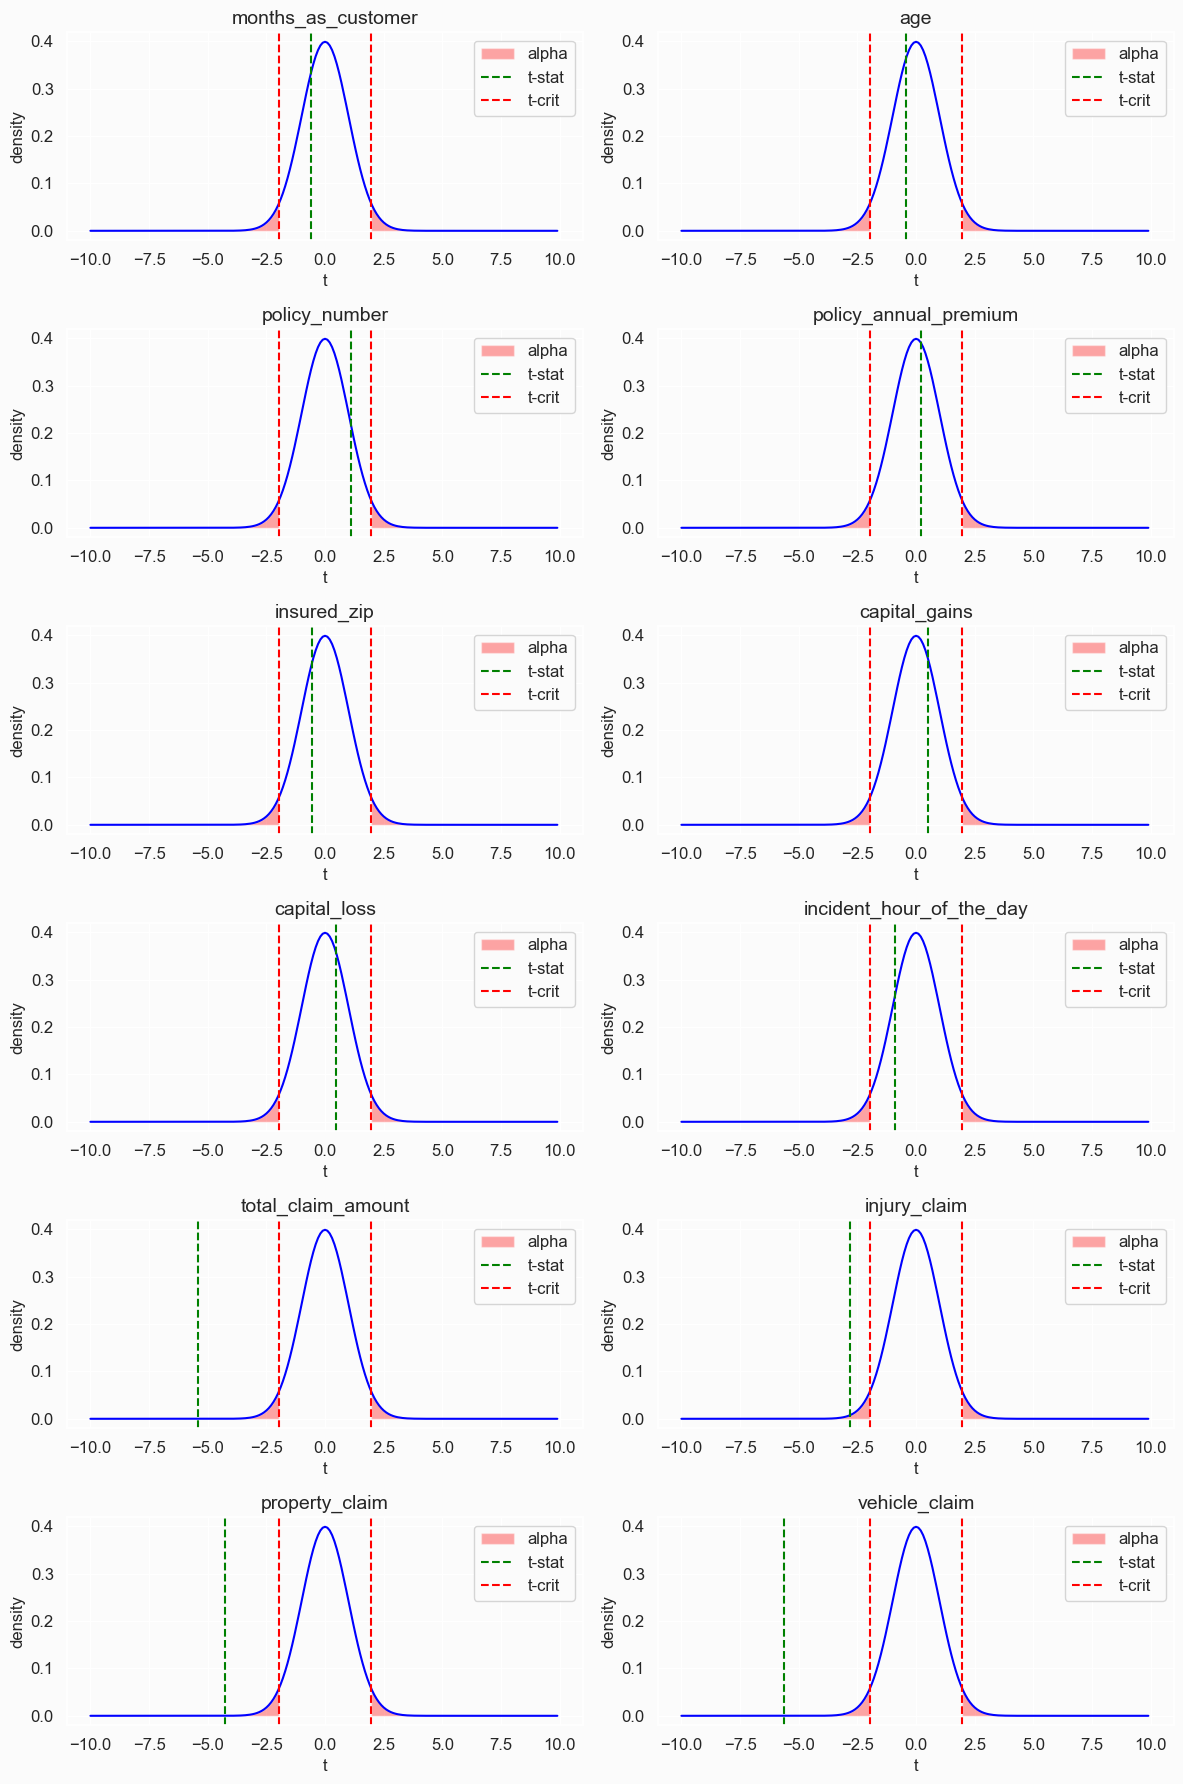

In [26]:
import scipy
from scipy.stats import ttest_ind

alpha = 0.05
fig, axes = plt.subplots(6, 2, figsize=(12, 18))  # Create subplots with 3 rows and 2 columns

welch_test = dict()

for i, ax in zip(list_num_col, axes.flatten()):
    
    lst_0 = train_set[i][train_set['fraud_reported']=='N']
    lst_1 = train_set[i][train_set['fraud_reported']=='Y']
    
    degree = lst_0.count() + lst_1.count()

    x = np.arange(-10,10,0.1)
    
    t_stat, p_value = ttest_ind(lst_0, lst_1, equal_var=False)
    t_crit = scipy.stats.t.ppf(alpha/2, degree)

    welch_test.setdefault('column', []).append(i)
    welch_test.setdefault('welch_test', []).append(round(p_value,5))

    if p_value < 0.05:
        welch_test.setdefault('result', []).append('Reject Ho')
    else:
        welch_test.setdefault('result', []).append('Failed to Reject Ho')
    
    ax.set_title(f"{i}", fontsize=14)  # Set the subplot title
    ax.plot(x, scipy.stats.norm.pdf(x, 0, 1), color='blue')  # Plot sample
    
    # plot alpha region
    x_alpha = np.arange(-10, t_crit, 0.01)
    y_alpha = scipy.stats.norm.pdf(x_alpha)
    ax.fill_between(x=x_alpha, y1=y_alpha, facecolor='red', alpha=0.35, label='alpha')
    
    # plot alpha region
    x_alpha = np.arange(-(t_crit), 10, 0.01)
    y_alpha = scipy.stats.norm.pdf(x_alpha)
    ax.fill_between(x=x_alpha, y1=y_alpha, facecolor='red', alpha=0.35)
    
    # plot z-crit and z-stats
    ax.axvline(np.round(t_stat, 4), color="green", linestyle="--", label="t-stat")
    ax.axvline(t_crit, color="red", linestyle="--", label="t-crit")
    ax.axvline(-(t_crit), color="red", linestyle="--")
    
    ax.legend(loc='best', fontsize=12)
    ax.set_xlabel("t", fontsize=12)
    ax.set_ylabel("density", fontsize=12)
    ax.tick_params(axis='both', labelsize=12)

welch_test = pd.DataFrame(welch_test).set_index('column')

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()

In [27]:
welch_test

,welch_test,result
column,,
months_as_customer,0.55839,Failed to Reject Ho
age,0.67810,Failed to Reject Ho
policy_number,0.26826,Failed to Reject Ho
policy_annual_premium,0.84827,Failed to Reject Ho
insured_zip,0.56632,Failed to Reject Ho
capital_gains,0.61308,Failed to Reject Ho
capital_loss,0.64122,Failed to Reject Ho
incident_hour_of_the_day,0.36763,Failed to Reject Ho
total_claim_amount,0.00000,Reject Ho


In [28]:
welch_test_feature = welch_test[welch_test['result']=='Reject Ho'].index.to_list()
welch_test_feature

['total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim']

Since the statistical test information regarding Two-Group Variable test to quantitative outcome show the result <br>
<br>
Besides, **Non-Equal variance** group show **Reject H0**, then these vairables is statistically significant


## <a id='toc2_3_'></a>[<b>3. Numeric vs Numeric (Multicollinearity)</b>](#toc0_)

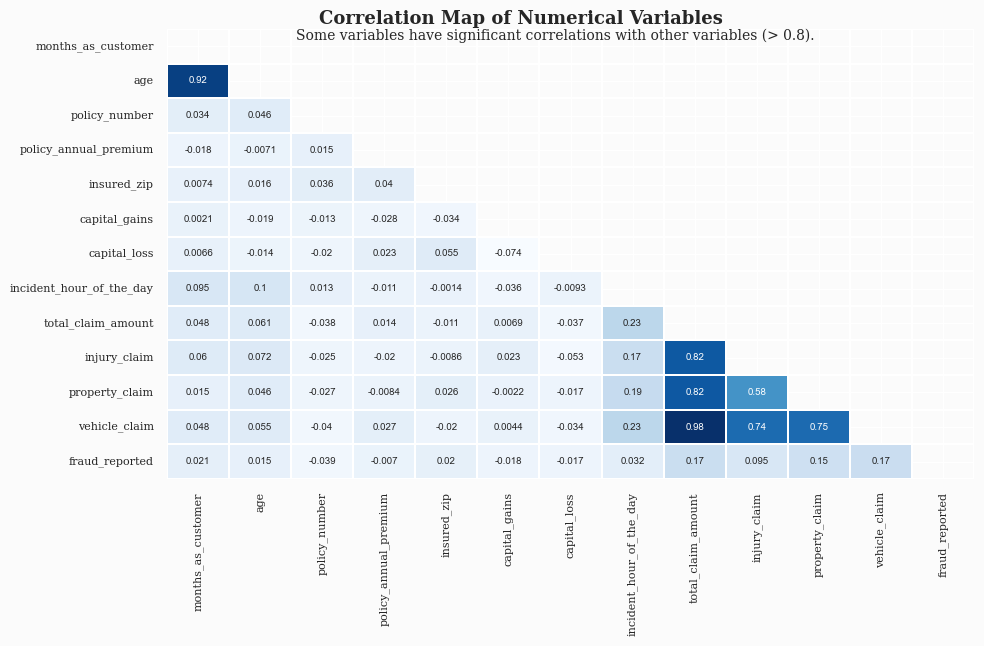

In [29]:
train_corr = train_set.copy()

train_corr.fraud_reported = train_corr.fraud_reported.map(dict(Y=1, N=0))

# -- Create Figure -- #
fig, ax = plt.subplots(figsize=(10,7))

# --- Create Correlation --- #
corr = train_corr[train_corr.select_dtypes(exclude='object').columns].corr()

# --- Create Mask --- #
mask = np.triu(np.ones_like(corr, dtype=bool))

# --- Cretea heatmap --- #
sns.heatmap(corr, annot=True, mask=mask, cmap='Blues', linewidths=0.1, cbar=False, annot_kws={"size":7})

# --- Figuration Setting --- #
yticks, ylabels = plt.yticks()
xticks, xlabels = plt.xticks()
ax.set_xticklabels(xlabels, size=8, fontfamily='serif')
ax.set_yticklabels(ylabels, size=8, fontfamily='serif')
plt.suptitle('Correlation Map of Numerical Variables', fontweight='heavy', x=0.327, y=0.96, ha='left', fontsize=13, fontfamily='serif')
plt.title('Some variables have significant correlations with other variables (> 0.8).\n', fontsize=10, x=0.16, y=0.92, fontfamily='serif', loc='left')
plt.tight_layout(rect=[0, 0.04, 1, 1.01])

In [30]:
import copy

# Create threshold of 0.8 correlation
corr_multi = corr[corr>=0.8].reset_index()

# melted to get the features with >= 0.8 value
melted_corr = pd.melt(copy.deepcopy(corr_multi), id_vars='index', var_name='column_name', value_name='correlation').sort_values(by=['correlation']).dropna()
melted_corr.columns = ['row_name', 'column_name', 'correlation']

# Drop the features that correlated each other
melted_corr = melted_corr[melted_corr['row_name'] != melted_corr['column_name']].drop_duplicates(subset='correlation')

melted_corr

,row_name,column_name,correlation
125,total_claim_amount,injury_claim,0.818404
138,total_claim_amount,property_claim,0.820697
1,age,months_as_customer,0.920221
151,total_claim_amount,vehicle_claim,0.984476


To reduce multicollinerity we can drop either **`total_claim_amount`** from the data, since **`total_claim_amount = injury_claim + property_claim + vehicle_claim`**

or the other three **(`injury_claim, property_claim, vehicle_claim`)**

## <a id='toc2_4_'></a>[<b>4. Lasso Method</b>](#toc0_)

In [31]:
# StandarScaler trains_set after Encoding
def _standard_scaler(data):
    ssc = StandardScaler()
    ssc.fit(data)
    
    train_scaled = ssc.transform(data)
    train_scaled = pd.DataFrame(train_scaled,
                                index=data.index,
                                columns=data.columns)
    
    return train_scaled

def Label_Encoder_(data):
    
    for col in data.columns.to_list():
        data[col] = LabelEncoder().fit_transform(data[col])
    
    return data

Text(0.5, 1.0, 'Feature Importance using Lasso Model')

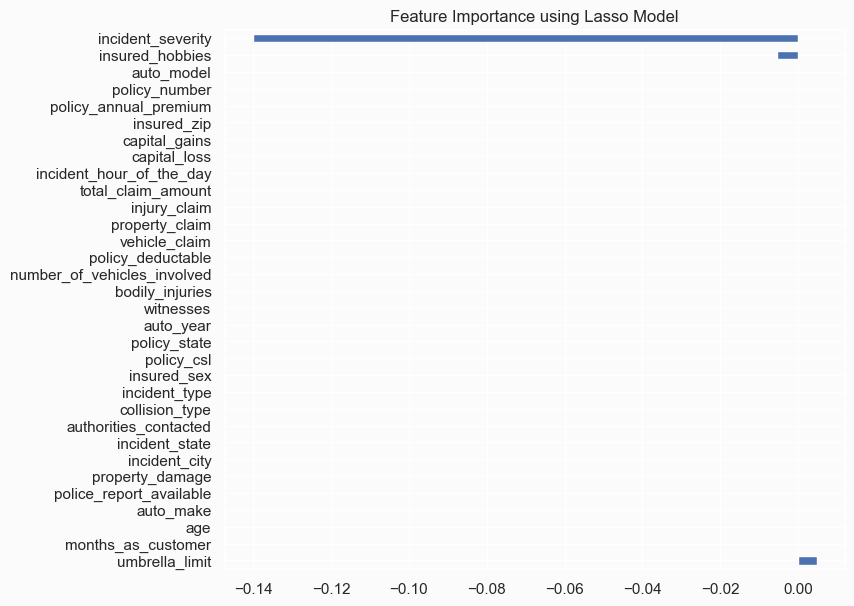

In [32]:
# ------------------------------------------
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

# Label Encoding

train_set_encoded = Label_Encoder_(train_set[list_cat_col])
train_set_encoded_ = pd.concat(
    [
        train_set[train_set.select_dtypes(exclude='object').columns.to_list()], 
        train_set_encoded.loc[:, ~train_set_encoded.columns.isin(['fraud_reported'])]
    ], 
    axis=1
)


train_scaled = _standard_scaler(train_set_encoded_)

train_scaled = pd.concat(
    [
        train_scaled, train_set_encoded['fraud_reported']
    ],
    axis=1
)

lasso_cv = LassoCV()

# Fit into train_set after StandardScaler
lasso_cv.fit(
    train_scaled.drop(columns='fraud_reported', axis=1),
    train_scaled['fraud_reported']
)

coef = pd.Series(lasso_cv.coef_, index = train_set[train_scaled.drop(columns='fraud_reported', axis=1).columns.to_list()].columns)

imp_coef = coef.sort_values(ascending=False)

import matplotlib

matplotlib.rcParams['figure.figsize'] = (8.0, 7.0)
imp_coef.plot(kind='barh')
plt.title('Feature Importance using Lasso Model')

In [33]:
lasso_cv.alpha_

0.025067137872476657

## <a id='toc2_5_'></a>[<b>5. XGBoost Method</b>](#toc0_)

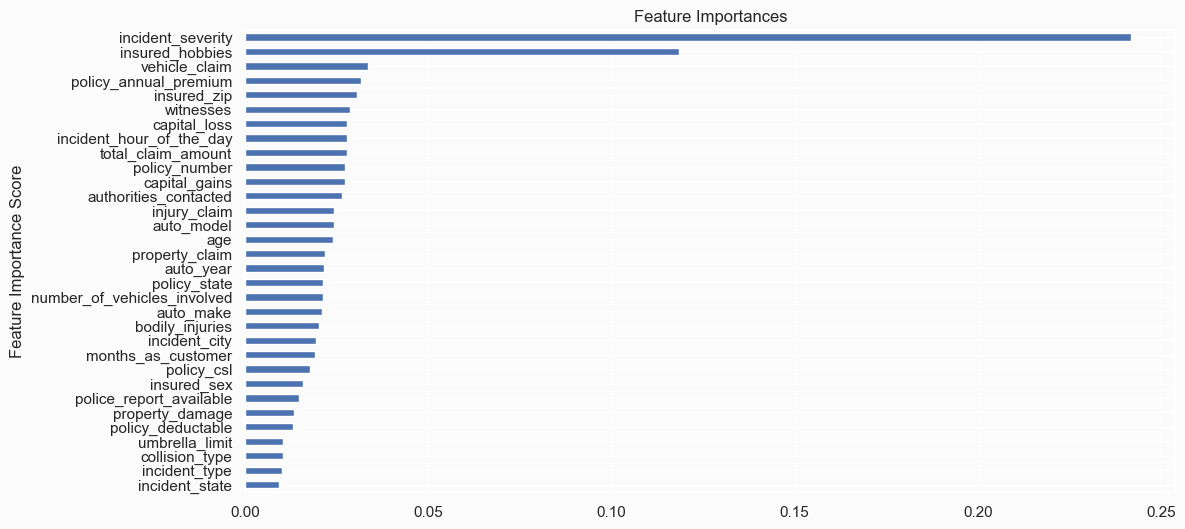

In [34]:
from xgboost import XGBClassifier

xgb = XGBClassifier()

xgb.fit(
    train_scaled.drop(columns='fraud_reported', axis=1),
    train_scaled['fraud_reported']
)

fig, ax = plt.subplots(figsize=(12,6))

feat_imp = pd.Series(

    xgb.feature_importances_, 
    train_scaled.drop(columns='fraud_reported', axis=1).columns.to_list()

).sort_values(ascending=True)

feat_imp.plot(kind='barh', title='Feature Importances')

plt.ylabel('Feature Importance Score')
plt.show()

## <a id='toc2_6_'></a>[<b>6. Random Forest</b>](#toc0_)

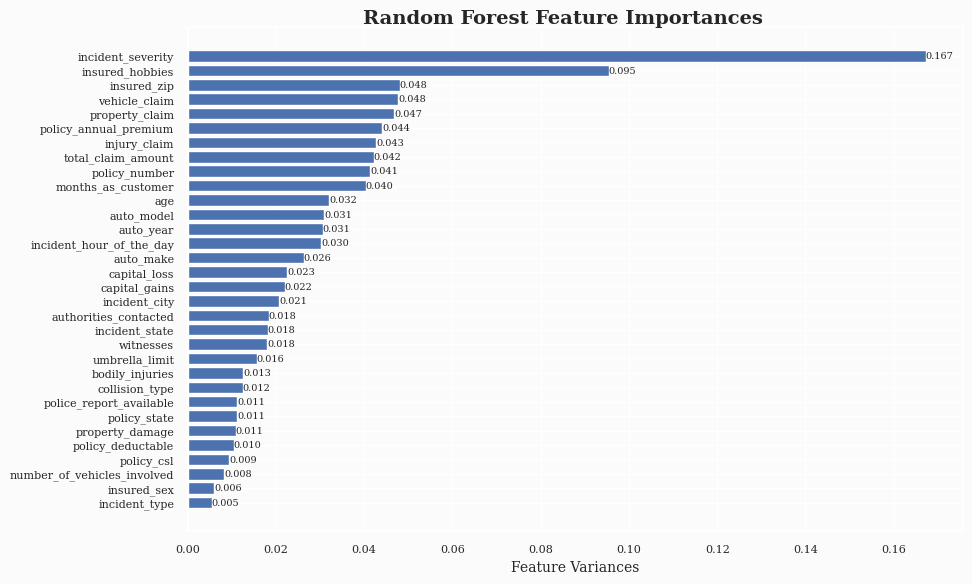

In [35]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

rf.fit(
    train_scaled.drop(columns='fraud_reported',axis=1), 
    train_scaled['fraud_reported']
)

sorted_index = rf.feature_importances_.argsort()
fig, ax = plt.subplots(figsize=(10,6))

fig.suptitle("Random Forest Feature Importances", fontsize=14, fontname='serif', fontweight='bold')
fig.subplots_adjust(top=0.95)

rf_importances = rf.feature_importances_[sorted_index]
rf_feature_names = train_scaled.drop(columns='fraud_reported',axis=1).columns[sorted_index]

ax.barh(rf_feature_names, rf_importances)

ax.set_xlabel("Feature Variances", fontsize=10, fontname='serif')
ax.set_xticklabels(ax.get_xticklabels(), fontname='serif', fontsize=8)
ax.set_yticklabels(rf_feature_names, fontname='serif', fontsize=8)

# Add labels to the bars
for i in range(len(rf_importances)):
    ax.text(rf_importances[i], i, f"{rf_importances[i]:.3f}", ha='left', va='center', fontsize=7, fontname='serif')


plt.show()

# <a id='toc3_'></a>[<b>Handling Imbalance Data</b>](#toc0_)
------

balancing data using <b>SMOTENC</b> and <b>Oversampling</b>, since using <b>Undersampling</b> can significantly reduce our data

In [36]:
x_train = util.pickle_load(config_data["train_set_path"][0])
y_train = util.pickle_load(config_data["train_set_path"][1])

x_valid = util.pickle_load(config_data["valid_set_path"][0])
y_valid = util.pickle_load(config_data["valid_set_path"][1])

x_test = util.pickle_load(config_data["test_set_path"][0])
y_test = util.pickle_load(config_data["test_set_path"][1])

In [37]:
valid_set = pd.concat([x_valid, y_valid], axis=1)
test_set = pd.concat([x_test, y_test], axis=1)

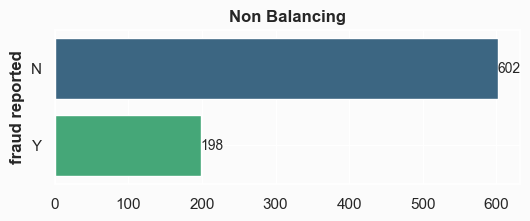

In [38]:
fig, ax = plt.subplots(figsize=(6,2))

ax = sns.countplot(data=train_set,
            y='fraud_reported',
            palette='viridis',
            ax=ax)

ax.bar_label(ax.containers[0], fontsize=10)
ax.grid(visible=True)
ax.set_ylabel('')
ax.set_title('Non Balancing', fontweight='bold')
ax.set_ylabel('fraud reported', fontsize=12, fontweight='bold')
ax.set_xlabel('')

plt.show()

## <a id='toc3_1_'></a>[<b>Balancing</b>](#toc0_)

In [39]:
# Using SMOTENC and Oversampling
def balancing(x_data, y_data):
    # --- numerical predictor on config--- #
    x_set_num = x_data[config_data['int32_col']]

    # --- categorical predictor on config --- #
    x_set_cat = x_data[config_data['object_predictor']]

    # --- New predictor --- #
    x_train_new = pd.concat([x_set_num, x_set_cat], axis=1)

    # --- SMOTENC --- #
    sm = SMOTENC(random_state=42, categorical_features = list(range(len(x_set_num.columns),32)))
    x_smote, y_smote = sm.fit_resample(x_train_new, y_data)

    # --- Oversampling --- #
    x_over, y_over = RandomOverSampler(random_state=42).fit_resample(x_data, y_data)

    # --- Concate Predictor and Label --- #
    train_set_smote = pd.concat([x_smote, y_smote], axis = 1)
    train_set_over = pd.concat([x_over, y_over], axis = 1)

    return train_set_smote, train_set_over

In [40]:
train_set_smote, train_set_over = balancing(x_train, y_train)
valid_set_smote, valid_set_over = balancing(x_valid, y_valid)
test_set_smote, test_set_over = balancing(x_test, y_test)

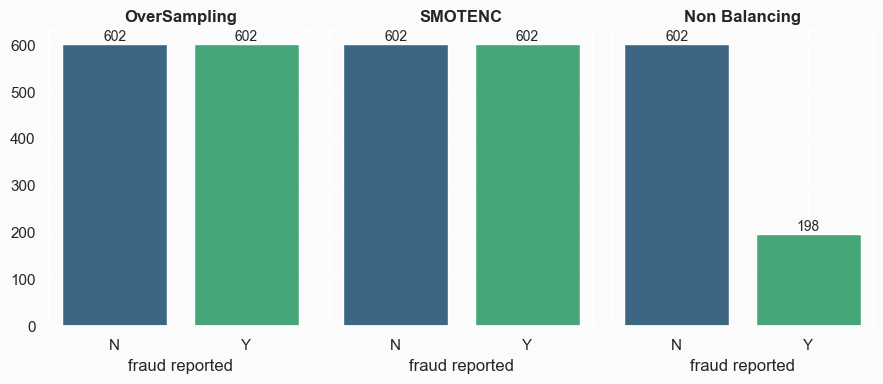

In [41]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9,4), sharey=True)

ax1 = sns.barplot(data=pd.DataFrame(train_set_over.fraud_reported.value_counts()).reset_index(),
            x='index',
            y='fraud_reported',
            palette='viridis',
            ax=ax1)

ax1.bar_label(ax1.containers[0], fontsize=10)
ax1.grid(visible=True)
ax1.set_ylabel('')
ax1.set_title('OverSampling', fontsize=12, fontweight='bold')
ax1.set_xlabel('fraud reported', fontsize=12)

ax2 = sns.barplot(data=pd.DataFrame(train_set_smote.fraud_reported.value_counts()).reset_index(),
            x='index',
            y='fraud_reported',
            palette='viridis',
            ax=ax2)

ax2.bar_label(ax2.containers[0], fontsize=10)
ax2.grid(visible=True)
ax2.set_ylabel('')
ax2.set_title('SMOTENC', fontsize=12, fontweight='bold')
ax2.set_xlabel('fraud reported', fontsize=12)

ax3 = sns.barplot(data=pd.DataFrame(y_train.value_counts()).reset_index(),
            x='index',
            y='fraud_reported',
            palette='viridis',
            ax=ax3)

ax3.bar_label(ax3.containers[0], fontsize=10)
ax3.grid(visible=True)
ax3.set_ylabel('')
ax3.set_title('Non Balancing', fontweight='bold')
ax3.set_xlabel('fraud reported', fontsize=12)

plt.tight_layout()
plt.show()

## <a id='toc3_2_'></a>[<b> Selected Features</b>](#toc0_)

In [42]:
## Feature from chi square test (categoric) and feature from welch's test (numeric)
selected_features = chi_score_feature + welch_test_feature

## Drop total_claim_amount based on pearson correlation collinearity
selected_features.remove('total_claim_amount')

## Append Fraud_reported as target variable
selected_features.append('fraud_reported')


In [43]:
train_set_eda = train_set.copy()[selected_features]

In [44]:
train_set_eda.head()

,insured_hobbies,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,property_damage,injury_claim,property_claim,vehicle_claim,fraud_reported
887,exercise,Parked Car,UNKNOWN,Minor Damage,UNKNOWN,VA,NO,640,640,5120,N
317,camping,Multi-vehicle Collision,Side Collision,Total Loss,Ambulance,VA,YES,5360,10720,48240,N
796,reading,Single Vehicle Collision,Rear Collision,Major Damage,Ambulance,NY,UNKNOWN,16860,8430,67440,Y
425,basketball,Multi-vehicle Collision,Side Collision,Major Damage,Police,WV,UNKNOWN,6080,12160,48640,Y
991,basketball,Single Vehicle Collision,Rear Collision,Total Loss,Other,WV,NO,0,5220,41760,N


In [45]:
train_set_smote_eda = train_set_smote.copy()[selected_features]
train_set_over_eda = train_set_over.copy()[selected_features]

In [46]:
train_set_smote_eda.head(10)

,insured_hobbies,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,property_damage,injury_claim,property_claim,vehicle_claim,fraud_reported
0,exercise,Parked Car,UNKNOWN,Minor Damage,UNKNOWN,VA,NO,640,640,5120,N
1,camping,Multi-vehicle Collision,Side Collision,Total Loss,Ambulance,VA,YES,5360,10720,48240,N
2,reading,Single Vehicle Collision,Rear Collision,Major Damage,Ambulance,NY,UNKNOWN,16860,8430,67440,Y
3,basketball,Multi-vehicle Collision,Side Collision,Major Damage,Police,WV,UNKNOWN,6080,12160,48640,Y
4,basketball,Single Vehicle Collision,Rear Collision,Total Loss,Other,WV,NO,0,5220,41760,N
5,skydiving,Multi-vehicle Collision,Rear Collision,Minor Damage,Ambulance,WV,NO,5940,2970,23760,N
6,golf,Multi-vehicle Collision,Rear Collision,Major Damage,Fire,SC,NO,12100,6050,42350,N
7,polo,Parked Car,UNKNOWN,Minor Damage,Police,SC,NO,620,620,4340,Y
8,chess,Multi-vehicle Collision,Rear Collision,Total Loss,Ambulance,NC,NO,4270,4270,34160,Y
9,camping,Parked Car,UNKNOWN,Trivial Damage,UNKNOWN,SC,UNKNOWN,630,630,5040,N


In [47]:
def select_features(data_1, data_2, data_3):
    data_1 = data_1[selected_features]
    data_2 = data_2[selected_features] 
    data_3 = data_3[selected_features]

    return data_1, data_2, data_3

In [48]:
valid_set_eda, valid_set_smote_eda, valid_set_over_eda = select_features(valid_set, valid_set_smote, valid_set_over)
test_set_eda, test_set_smote_eda, test_set_over_eda = select_features(test_set, test_set_smote, test_set_over)

In [49]:
valid_set_eda

,insured_hobbies,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,property_damage,injury_claim,property_claim,vehicle_claim,fraud_reported
499,camping,Single Vehicle Collision,Side Collision,Minor Damage,Other,NC,YES,13340,6670,53360,N
888,chess,Single Vehicle Collision,Rear Collision,Major Damage,Fire,SC,YES,12120,6060,42420,N
151,polo,Multi-vehicle Collision,Rear Collision,Major Damage,Fire,NC,UNKNOWN,10680,5340,32040,N
731,polo,Single Vehicle Collision,Side Collision,Major Damage,Ambulance,VA,UNKNOWN,6060,6060,54540,N
673,golf,Single Vehicle Collision,Rear Collision,Major Damage,Police,SC,UNKNOWN,3720,3720,26040,N
...,...,...,...,...,...,...,...,...,...,...,...
694,reading,Multi-vehicle Collision,Rear Collision,Total Loss,Other,WV,UNKNOWN,0,11400,45600,N
988,dancing,Single Vehicle Collision,Rear Collision,Minor Damage,Fire,NY,YES,12140,6070,42490,N
819,camping,Single Vehicle Collision,Side Collision,Minor Damage,Other,SC,YES,5590,11180,44720,N
228,kayaking,Multi-vehicle Collision,Front Collision,Total Loss,Fire,WV,YES,6560,6560,45920,N


--------

## <a id='toc3_3_'></a>[Check Map Correlations using PPS](#toc0_)

In [50]:
import ppscore as pps

In [51]:
pps_score = pps.matrix(train_set_eda).set_index('x')

pps_score[(pps_score['y']=='fraud_reported') & (pps_score['ppscore']>0.01)]

,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
x,,,,,,,,
insured_hobbies,fraud_reported,0.362860,classification,True,weighted F1,0.646227,0.774597,DecisionTreeClassifier()
incident_severity,fraud_reported,0.461061,classification,True,weighted F1,0.646227,0.809338,DecisionTreeClassifier()
property_claim,fraud_reported,0.101242,classification,True,weighted F1,0.646227,0.682044,DecisionTreeClassifier()
vehicle_claim,fraud_reported,0.021622,classification,True,weighted F1,0.646227,0.653876,DecisionTreeClassifier()
fraud_reported,fraud_reported,1.000000,predict_itself,True,None,0.000000,1.000000,None


## <a id='toc3_4_'></a>[Handling Outliers data](#toc0_)

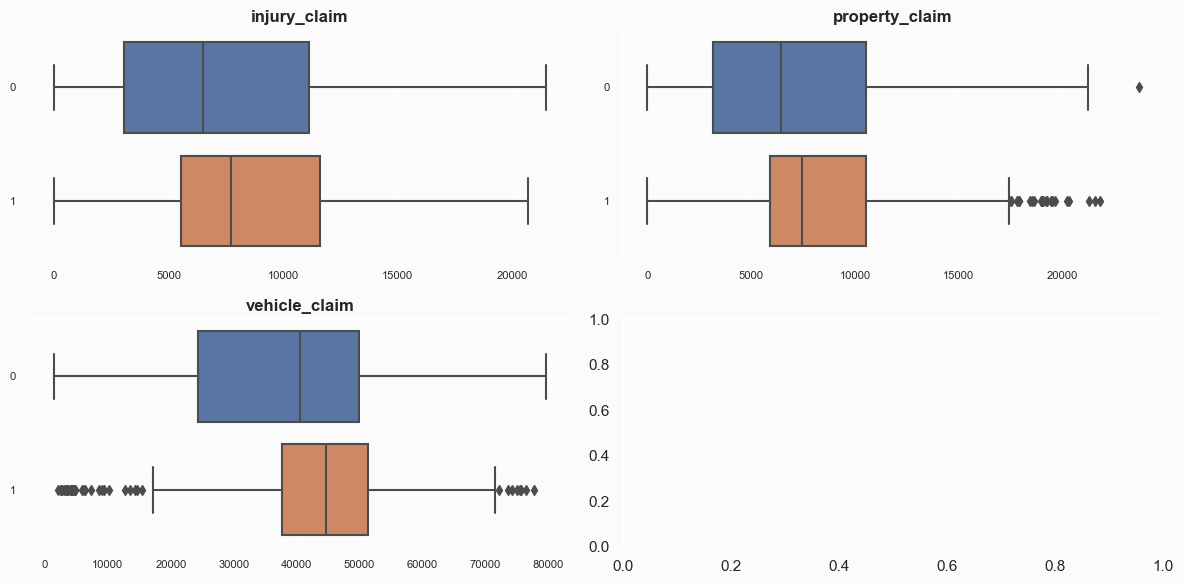

In [52]:
list_num_col_smote_eda = []

for col in train_set_smote_eda.columns:
    if (train_set_smote_eda[col].dtype == 'int32'):
        list_num_col_smote_eda.append(col)

fig, axs = plt.subplots(2, 2, figsize=(12,6))
count = 0

train_set_box = train_set_smote_eda.copy()
train_set_box.fraud_reported = train_set_box.fraud_reported.map(dict(Y=1,N=0))

for i in range(2):
    for j in range(2):

        if count >= len(list_num_col_smote_eda):
            break

        sns.boxplot(data = train_set_box, x=list_num_col_smote_eda[count], y='fraud_reported', ax=axs[i, j], orient='h')

        axs[i, j].tick_params(axis='x', labelsize=8)
        axs[i, j].tick_params(axis='y', labelsize=8)

        axs[i, j].set_xlabel('')
        axs[i, j].set_ylabel('')
        axs[i, j].set_title(list_num_col_smote_eda[count], fontweight='bold')

        count += 1


plt.tight_layout()
plt.show()

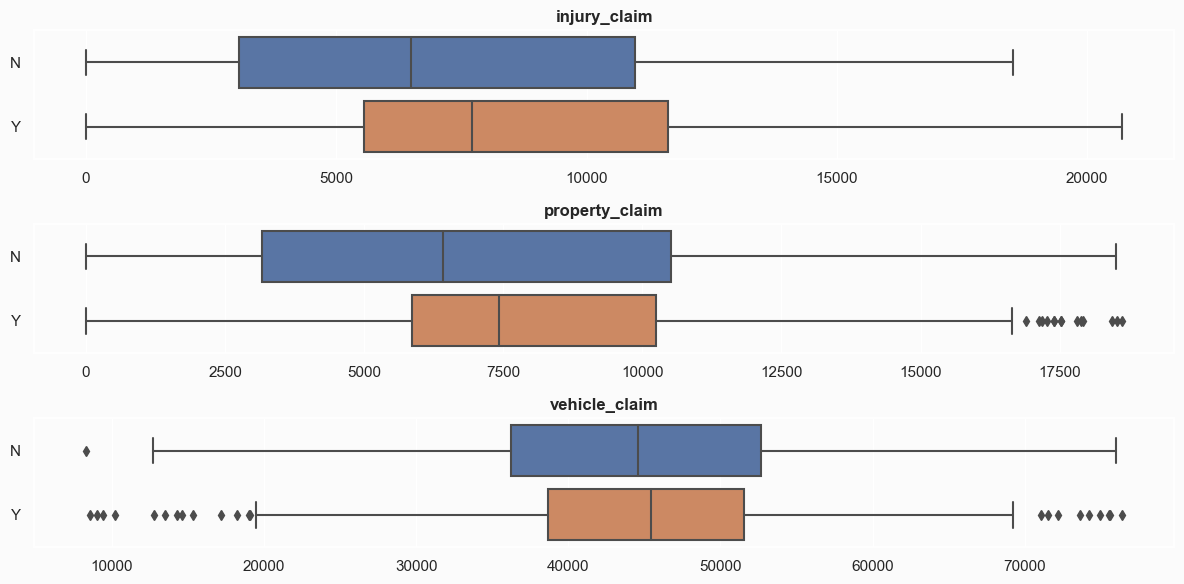

In [53]:
fig, axs = plt.subplots(3, 1, figsize=(12,6))
count = 0

for i, col in enumerate(list_num_col_smote_eda):

    if count >= len(list_num_col_smote_eda):
            break

    q1 = train_set_smote_eda[col].quantile(0.25)
    q3 = train_set_smote_eda[col].quantile(0.75)
    iqr = q3-q1

    train_set_smote_annual = train_set_smote_eda[~((train_set_smote_eda[col] < (q1 - 1.5*iqr)) |
                                            (train_set_smote_eda[col] > (q3 + 1.5*iqr)))].copy()

    sns.boxplot(data=train_set_smote_annual, x=col, ax=axs[i], y='fraud_reported')

    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    axs[i].set_title(list_num_col_smote_eda[count], fontweight='bold')

    count += 1

fig.tight_layout()
plt.show()

## <a id='toc3_5_'></a>[Pairplot](#toc0_)

In [54]:
train_set_pair_plot = train_set_eda.copy()

train_set_pair_plot.fraud_reported = train_set_pair_plot.fraud_reported.map(dict(Y=1, N=0))

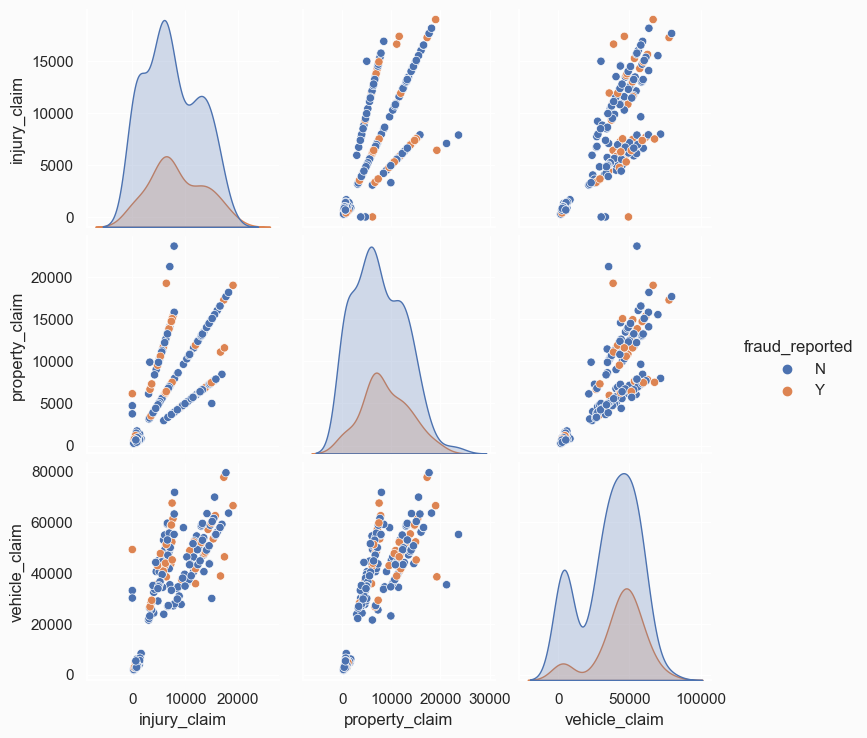

In [55]:
sns.pairplot(
    train_set_eda[
        train_set_pair_plot.select_dtypes(exclude='object').columns
    ].sample(200),
    hue = config_data['label']
)

# <a id='toc4_'></a>[Store Data to Directory](#toc0_)

In [56]:
config_data = util.load_config()

In [57]:
def split_data(data):
    x = data.drop(columns='fraud_reported', axis=1)
    y = data.fraud_reported

    return x, y


def dict_data(data_1, data_2, data_3):

    x_1, y_1 = split_data(data_1)
    x_2, y_2 = split_data(data_2)
    x_3, y_3 = split_data(data_3)

    x_ = {
        "nonbalance" : x_1,
        "smote" : x_2,
        "oversampling" : x_3
    }

    y_ = {
        "nonbalance" : y_1,
        "smote" : y_2,
        "oversampling" : y_3
    }

    return x_, y_

In [58]:
x_train_eda, y_train_eda = dict_data(train_set_eda, train_set_smote_eda, train_set_over_eda)
x_valid_eda, y_valid_eda = dict_data(valid_set_eda, valid_set_smote_eda, valid_set_over_eda)
x_test_eda, y_test_eda = dict_data(test_set_eda, test_set_smote_eda, test_set_over_eda)

In [59]:
util.pickle_dump(x_train_eda, config_data['train_set_eda'][0])
util.pickle_dump(y_train_eda, config_data['train_set_eda'][1])

util.pickle_dump(x_valid_eda, config_data['valid_set_eda'][0])
util.pickle_dump(y_valid_eda, config_data['valid_set_eda'][1])

util.pickle_dump(x_test_eda, config_data['test_set_eda'][0])
util.pickle_dump(y_test_eda, config_data['test_set_eda'][1])